***Instrucciones***  
Realizar un análisis no supervisado sobre el dataset 'analisis.csv' que contiene datos sobre famosos y que  
esta basado en una metodología de psicología conocida como “Ocean: The Big Five”.  
Disponemos de las siguientes características de entrada:  
- usuario (el nombre en Twitter)  
- “op” = Openness to experience – grado de apertura mental a nuevas experiencias, curiosidad, arte  
- “co” =Conscientiousness – grado de orden, prolijidad, organización  
- “ex” = Extraversion – grado de timidez, solitario o participación ante el grupo social  
- “ag” = Agreeableness – grado de empatía con los demás, temperamento  
- “ne” = Neuroticism, – grado de neuroticismo, nervioso, irritabilidad, seguridad en sí mismo.  
- Wordcount – Cantidad promedio de palabras usadas en sus tweets  
- Categoria – Actividad laboral del usuario (actor, cantante, etc.)  
  
Eliminando la columna 'Categoría', realizar la tarea usando los 3 algoritmos de ANS:  
K-Means, DBScan y Jerárquico.  
Podemos suponer que, para 'profesiones' similares tendremos 'carácteres' similares.  
Se debe investigar los posibles clústers que se pueden generar.  
Es interesante realizar un EDA previo con los datos completos, para tener una idea inicial.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

# Cargar el dataset
df = pd.read_csv("analisis.csv")


In [43]:
# --- Análisis Exploratorio de Datos (EDA) ---
print("Forma del dataset:", df.shape)
print(df.head())
print(df.describe())
print(df.info())




Forma del dataset: (140, 8)
           usuario         op         co         ex         ag         ne  \
0     3gerardpique  34.297953  28.148819  41.948819  29.370315   9.841575   
1  aguerosergiokun  44.986842  20.525865  37.938947  24.279098  10.362406   
2   albertochicote  41.733854  13.745417  38.999896  34.645521   8.836979   
3    AlejandroSanz  40.377154  15.377462  52.337538  31.082154   5.032231   
4   alfredocasero1  36.664677  19.642258  48.530806  31.138871   7.305968   

   wordcount  categoria  
0    37.0945          7  
1    78.7970          7  
2    49.2604          4  
3    80.4538          2  
4    47.0645          4  
               op          co          ex          ag          ne   wordcount  \
count  140.000000  140.000000  140.000000  140.000000  140.000000  140.000000   
mean    44.414591   22.977135   40.764428   22.918528    8.000098   98.715484   
std      8.425723    5.816851    7.185246    7.657122    3.039248   44.714071   
min     30.020465    7.852756

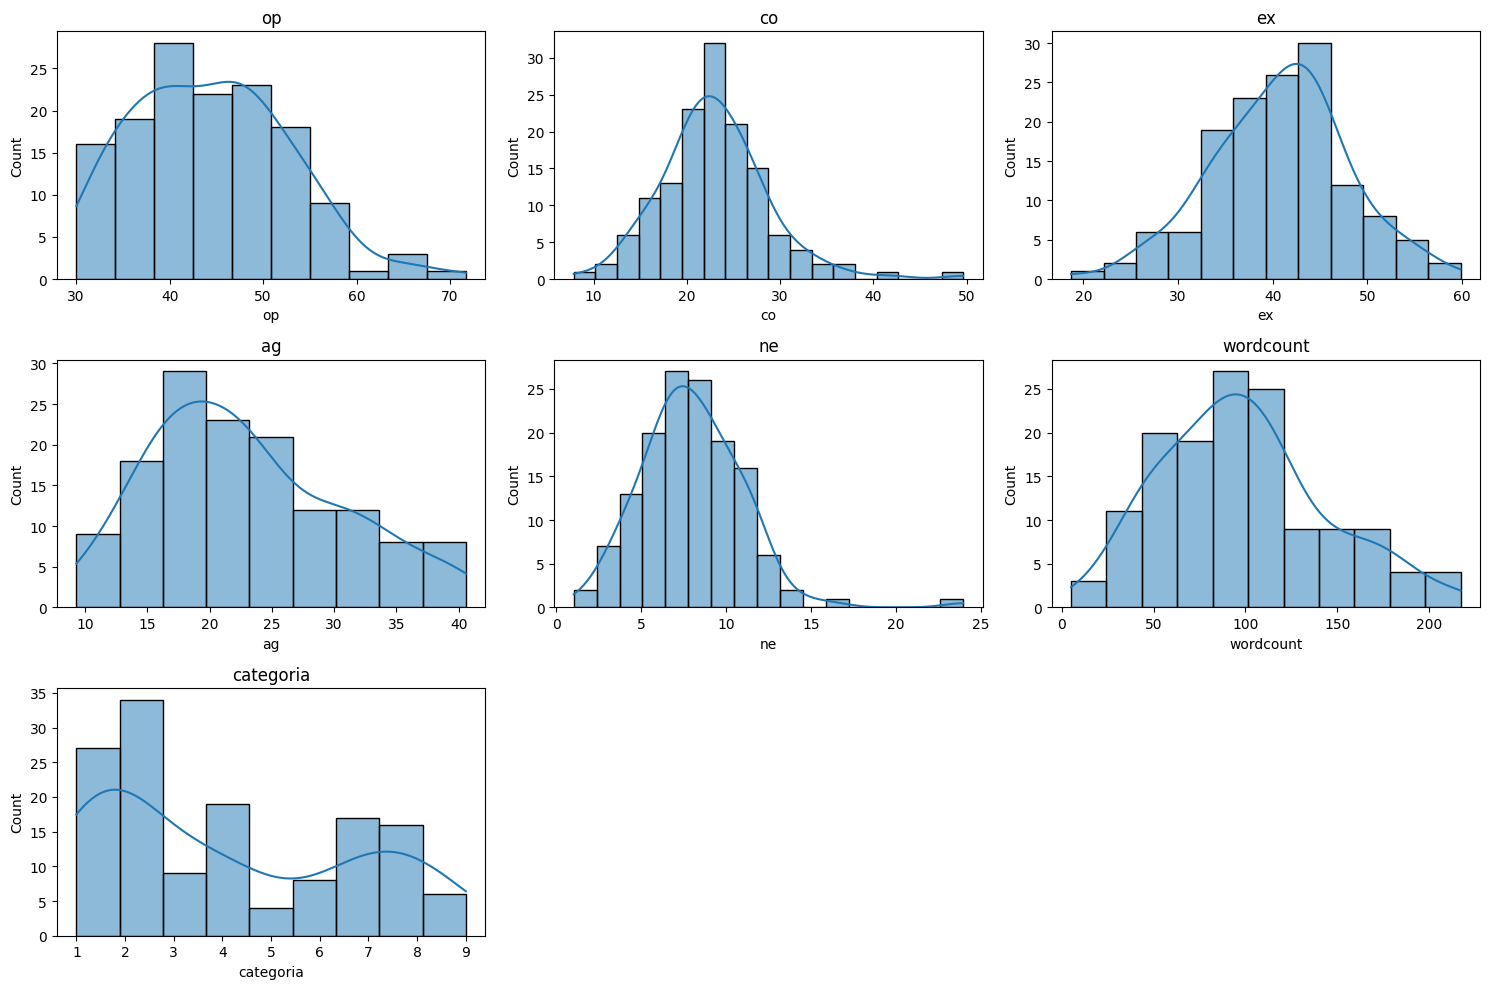

In [44]:
# Visualizar la distribución de las características
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns[1:]):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

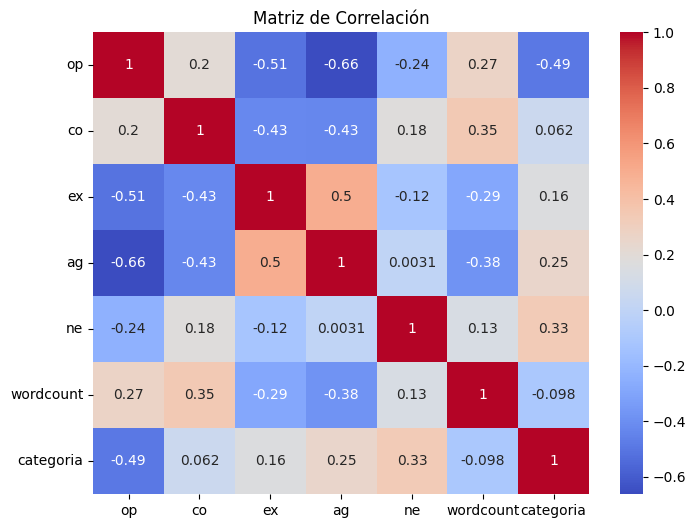

In [45]:
# Visualizar las correlaciones
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

In [46]:
# Eliminar las columnas 'categoria' y 'usuario' para el análisis no supervisado
df_cluster = df.drop(["categoria", "usuario"], axis=1)

# --- Preprocesamiento de Datos ---
# Escalamiento de datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)


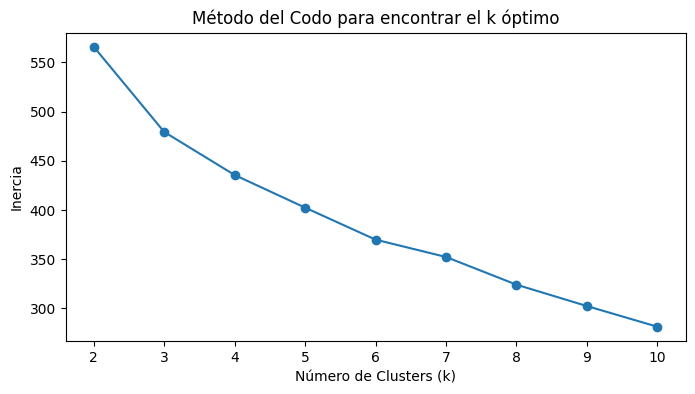

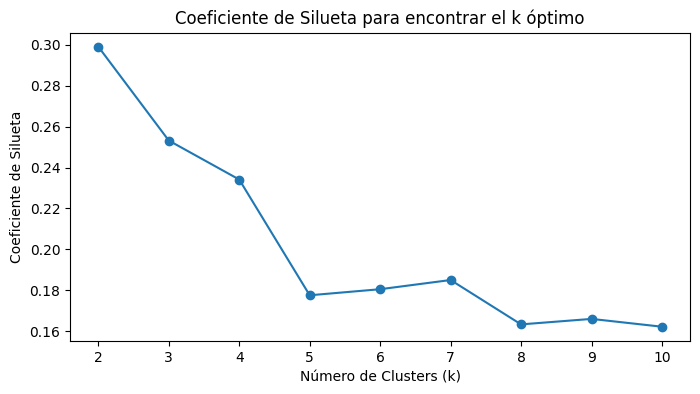


Análisis de Clusters K-Means:
                      op         co         ex         ag         ne  \
KMeans_labels                                                          
0              37.002882  19.048125  46.803142  31.161090   7.311701   
1              53.455552  21.906267  37.690207  17.180141   6.042889   
2              42.531387  23.624384  38.470436  22.167313  11.620183   
3              45.460306  28.752974  37.366934  18.707180   9.123532   

                wordcount  
KMeans_labels              
0               62.864117  
1              108.192868  
2              167.318167  
3              101.148600  


In [47]:
# --- K-Means Clustering ---
# Encontrar el k óptimo usando el Método del Codo y el Coeficiente de Silueta
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Método del Codo
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker="o")
plt.title("Método del Codo para encontrar el k óptimo")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia")
plt.show()

# Coeficiente de Silueta
plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, marker="o")
plt.title("Coeficiente de Silueta para encontrar el k óptimo")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Coeficiente de Silueta")
plt.show()

# Elegir k basado en el método del codo y el coeficiente de silueta (digamos 4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
df_cluster["KMeans_labels"] = kmeans.fit_predict(df_scaled)

# Analizar los clusters de K-Means
print("\nAnálisis de Clusters K-Means:")
kmeans_analysis = df_cluster.groupby("KMeans_labels").mean()
print(kmeans_analysis)



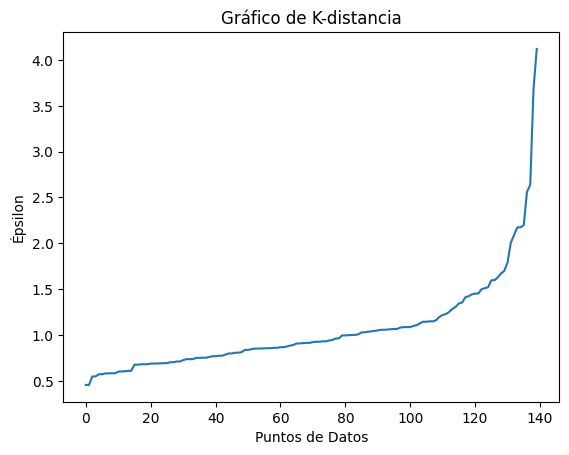


Análisis de Clusters DBSCAN:
                      op         co         ex         ag        ne  \
DBSCAN_labels                                                         
-1             44.699068  23.097937  40.533447  22.539734  7.954257   
 0             36.733703  19.715499  47.000916  33.145955  9.237788   

                wordcount  KMeans_labels  
DBSCAN_labels                             
-1             100.036289        1.37037  
 0              63.053740        0.00000  


In [48]:
# --- DBSCAN Clustering ---
# Encontrar el épsilon óptimo usando el gráfico de k-distancia

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.title("Gráfico de K-distancia")
plt.xlabel("Puntos de Datos")
plt.ylabel("Épsilon")
plt.show()

# Elegir épsilon y min_samples basado en el gráfico de k-distancia (digamos 0.8 y 5)
dbscan = DBSCAN(eps=0.8, min_samples=5)
df_cluster["DBSCAN_labels"] = dbscan.fit_predict(df_scaled)

# Analizar los clusters de DBSCAN
print("\nAnálisis de Clusters DBSCAN:")
dbscan_analysis = df_cluster.groupby("DBSCAN_labels").mean()
print(dbscan_analysis)



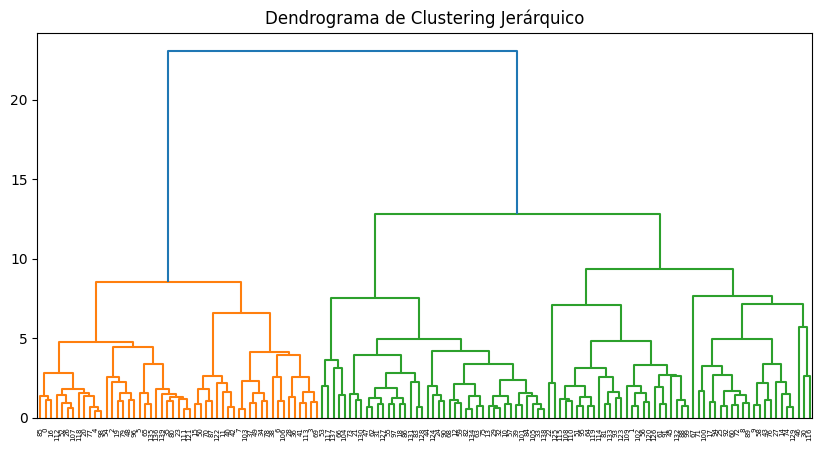


Análisis de Clusters Jerárquico:
                            op         co         ex         ag         ne  \
Hierarchical_labels                                                          
0                    38.161893  19.304132  46.815814  30.362315   7.143658   
1                    42.965519  26.878851  37.065381  20.640603  11.034157   
2                    53.800834  23.282510  37.193500  16.778179   6.500428   
3                    43.104253  26.398868  37.655444  19.927586   9.477620   

                      wordcount  KMeans_labels  DBSCAN_labels  
Hierarchical_labels                                            
0                     63.935053       0.137255      -0.901961  
1                    167.735964       2.227273      -1.000000  
2                    113.298859       1.365854      -1.000000  
3                     85.539831       2.807692      -1.000000  


In [49]:
# --- Clustering Jerárquico ---
# Dendrograma
linked = linkage(df_scaled, method="ward")
plt.figure(figsize=(10, 5))
dendrogram(linked, orientation="top")
plt.title("Dendrograma de Clustering Jerárquico")
plt.show()

# Elegir el número de clusters basado en el dendrograma (digamos 4)
hierarchical = AgglomerativeClustering(n_clusters=4, linkage="ward")
df_cluster["Hierarchical_labels"] = hierarchical.fit_predict(df_scaled)

# Analizar los clusters jerárquicos
print("\nAnálisis de Clusters Jerárquico:")
hierarchical_analysis = df_cluster.groupby("Hierarchical_labels").mean()
print(hierarchical_analysis)



In [50]:
# --- Comparacion de los algoritmos ---
df_cluster['usuario'] = df['usuario']
comparacion = pd.DataFrame({
    'usuario': df_cluster['usuario'],
    'kmeans': df_cluster['KMeans_labels'],
    'dbscan': df_cluster['DBSCAN_labels'],
    'jerarquico': df_cluster['Hierarchical_labels']
})
print(comparacion.head(10))



           usuario  kmeans  dbscan  jerarquico
0     3gerardpique       0      -1           0
1  aguerosergiokun       3      -1           3
2   albertochicote       0      -1           0
3    AlejandroSanz       0      -1           0
4   alfredocasero1       0      -1           0
5      alo_oficial       0      -1           0
6   andresiniesta8       0      -1           0
7   andykusnetzoff       0      -1           0
8      andyroddick       3      -1           1
9      andy_murray       2      -1           1


In [58]:
# --- Interpretación y Análisis de Clusters ---

def describe_cluster(cluster_data, cluster_name):
    """Proporciona una descripción textual de un cluster basado en sus medias de características."""
    print(f"\n--- Descripción del Cluster {cluster_name} ---")
    for feature, avg_value in cluster_data.items():
        print(f"- {feature}: {avg_value:.2f}", end=". ")
        if feature == "op":
            if avg_value > 45:
                print("Alta Apertura a la Experiencia.")
            elif avg_value > 35:
                print("Moderada Apertura a la Experiencia.")
            else:
                print("Baja Apertura a la Experiencia.")
        elif feature == "co":
            if avg_value > 25:
                print("Alta Conciencia.")
            elif avg_value > 15:
                print("Moderada Conciencia.")
            else:
                print("Baja Conciencia.")
        elif feature == "ex":
            if avg_value > 45:
                print("Alta Extraversión.")
            elif avg_value > 35:
                print("Moderada Extraversión.")
            else:
                print("Baja Extraversión.")
        elif feature == "ag":
            if avg_value > 30:
                print("Alta Amabilidad.")
            elif avg_value > 20:
                print("Moderada Amabilidad.")
            else:
                print("Baja Amabilidad.")
        elif feature == "ne":
            if avg_value > 12:
                print("Alto Neuroticismo.")
            elif avg_value > 8:
                print("Moderado Neuroticismo.")
            else:
                print("Bajo Neuroticismo.")
        elif feature == "wordcount":
            if avg_value > 120:
                print("Alto Recuento de Palabras.")
            elif avg_value > 60:
                print("Moderado Recuento de Palabras.")
            else:
                print("Bajo Recuento de Palabras.")

# Describir los Clusters de K-Means
for cluster_label in kmeans_analysis.index:
    describe_cluster(kmeans_analysis.loc[cluster_label], f"K-Means {cluster_label}")

# Describir los Clusters de DBSCAN
for cluster_label in dbscan_analysis.index:
    describe_cluster(dbscan_analysis.loc[cluster_label], f"DBSCAN {cluster_label}")

# Describir los Clusters Jerárquicos
for cluster_label in hierarchical_analysis.index:
    describe_cluster(hierarchical_analysis.loc[cluster_label], f"Jerárquico {cluster_label}")



--- Descripción del Cluster K-Means 0 ---
- op: 37.00. Moderada Apertura a la Experiencia.
- co: 19.05. Moderada Conciencia.
- ex: 46.80. Alta Extraversión.
- ag: 31.16. Alta Amabilidad.
- ne: 7.31. Bajo Neuroticismo.
- wordcount: 62.86. Moderado Recuento de Palabras.

--- Descripción del Cluster K-Means 1 ---
- op: 53.46. Alta Apertura a la Experiencia.
- co: 21.91. Moderada Conciencia.
- ex: 37.69. Moderada Extraversión.
- ag: 17.18. Baja Amabilidad.
- ne: 6.04. Bajo Neuroticismo.
- wordcount: 108.19. Moderado Recuento de Palabras.

--- Descripción del Cluster K-Means 2 ---
- op: 42.53. Moderada Apertura a la Experiencia.
- co: 23.62. Moderada Conciencia.
- ex: 38.47. Moderada Extraversión.
- ag: 22.17. Moderada Amabilidad.
- ne: 11.62. Moderado Neuroticismo.
- wordcount: 167.32. Alto Recuento de Palabras.

--- Descripción del Cluster K-Means 3 ---
- op: 45.46. Alta Apertura a la Experiencia.
- co: 28.75. Alta Conciencia.
- ex: 37.37. Moderada Extraversión.
- ag: 18.71. Baja Amabili

In [68]:
# Ejecución del algoritmo DBSCAN
epsilon = 0.16  # Selección basada en la gráfica "distancia-k"
min_samples = 6  # 2 * n_features (2 * 2 = 4) como mínimo. Seleccionamos 5 para tener al menos un outlier
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples) # Creación del modelo
clusters = dbscan.fit_predict(df_scaled) # Entrenamiento y predicción

In [ ]:
# Visualización de los clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
plt.colorbar(scatter)
plt.title('Resultado del clustering con DBSCAN')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.show()

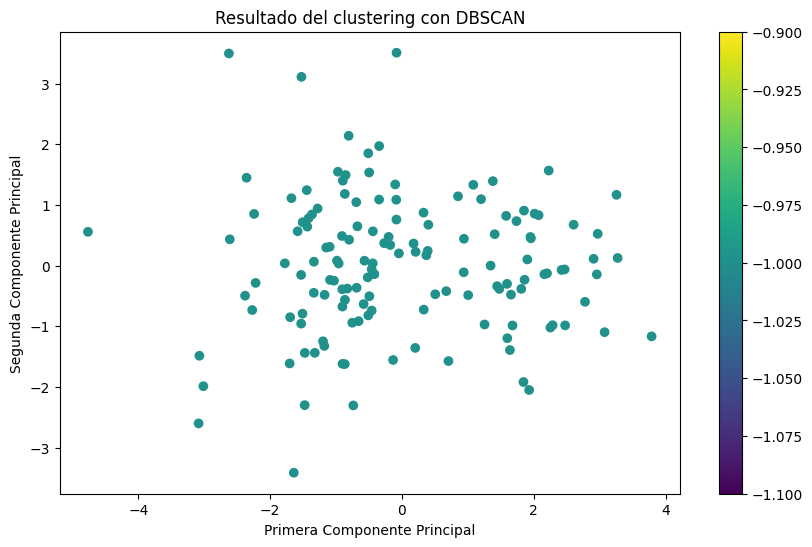

In [70]:
# Reducción de dimensionalidad para visualización
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)

# Visualización de los clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar(scatter)
plt.title('Resultado del clustering con DBSCAN')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.show()

In [ ]:
# Número de clusters y puntos de ruido
print("Número total de clústers detectados: ", len(set(clusters))) # Número de clusters total. 2 clusters + 1 de ruido(outliers)
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0) # Restamos 1 si hay ruido. set(clusters) nos da los clusters únicos
n_noise = list(clusters).count(-1) # Contamos cuántos puntos hay en el cluster de ruido. Son los puntos que tienen cluster -1
print(f'Número de clústers reales: {n_clusters}')
print(f'Número de puntos de ruido: {n_noise}')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

# Cargar el dataset
try:
    df = pd.read_csv("analisis.csv")
except FileNotFoundError:
    try:
        df = pd.read_csv('/workspaces/workspaceAI/CEIABD_MODULOS_IA/_Ejercicios/analisis.csv')
    except FileNotFoundError:
        df = pd.read_csv('/workspaces/workspaceAI/CEIABD_MODULOS_IA/SISTEMAS DE APRENDIZAJE AUTOMATICO/NOTEBOOKS DEL AULA/Aprendizaje No Supervisado/datasets/analisis.csv')

# --- Análisis Exploratorio de Datos (EDA) ---
print("Forma del dataset:", df.shape)
print(df.head())
print(df.describe())
print(df.info())

# Visualizar la distribución de las características
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns[1:]):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Visualizar las correlaciones
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

# Eliminar las columnas 'categoria' y 'usuario' para el análisis no supervisado
df_cluster = df.drop(["categoria", "usuario"], axis=1)

# --- Preprocesamiento de Datos ---
# Escalamiento de datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# --- K-Means Clustering ---
# Encontrar el k óptimo usando el Método del Codo y el Coeficiente de Silueta
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Método del Codo
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker="o")
plt.title("Método del Codo para encontrar el k óptimo")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia")
plt.show()

# Coeficiente de Silueta
plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, marker="o")
plt.title("Coeficiente de Silueta para encontrar el k óptimo")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Coeficiente de Silueta")
plt.show()

# Elegir k basado en el método del codo y el coeficiente de silueta (digamos 4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
df_cluster["KMeans_labels"] = kmeans.fit_predict(df_scaled)

# Analizar los clusters de K-Means
print("\nAnálisis de Clusters K-Means:")
kmeans_analysis = df_cluster.groupby("KMeans_labels").mean()
print(kmeans_analysis)

# --- DBSCAN Clustering ---
# Encontrar el épsilon óptimo usando el gráfico de k-distancia

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.title("Gráfico de K-distancia")
plt.xlabel("Puntos de Datos")
plt.ylabel("Épsilon")
plt.show()

# Elegir épsilon y min_samples basado en el gráfico de k-distancia (digamos 0.8 y 5)
dbscan = DBSCAN(eps=0.8, min_samples=5)
df_cluster["DBSCAN_labels"] = dbscan.fit_predict(df_scaled)

# Analizar los clusters de DBSCAN
print("\nAnálisis de Clusters DBSCAN:")
dbscan_analysis = df_cluster.groupby("DBSCAN_labels").mean()
print(dbscan_analysis)

# --- Clustering Jerárquico ---
# Dendrograma
linked = linkage(df_scaled, method="ward")
plt.figure(figsize=(10, 5))
dendrogram(linked, orientation="top")
plt.title("Dendrograma de Clustering Jerárquico")
plt.show()

# Elegir el número de clusters basado en el dendrograma (digamos 4)
hierarchical = AgglomerativeClustering(n_clusters=4, linkage="ward")
df_cluster["Hierarchical_labels"] = hierarchical.fit_predict(df_scaled)

# Analizar los clusters jerárquicos
print("\nAnálisis de Clusters Jerárquico:")
hierarchical_analysis = df_cluster.groupby("Hierarchical_labels").mean()
print(hierarchical_analysis)

# --- Comparacion de los algoritmos ---
df_cluster['usuario'] = df['usuario']
comparacion = pd.DataFrame({
    'usuario': df_cluster['usuario'],
    'kmeans': df_cluster['KMeans_labels'],
    'dbscan': df_cluster['DBSCAN_labels'],
    'jerarquico': df_cluster['Hierarchical_labels']
})
print(comparacion.head(10))

# --- Interpretación y Análisis de Clusters ---

def describe_cluster(cluster_data, cluster_name):
    """Proporciona una descripción textual de un cluster basado en sus medias de características."""
    print(f"\n--- Descripción del Cluster {cluster_name} ---")
    for feature, avg_value in cluster_data.items():
        print(f"- {feature}: {avg_value:.2f}", end=". ")
        if feature == "op":
            if avg_value > 45:
                print("Alta Apertura a la Experiencia.")
            elif avg_value > 35:
                print("Moderada Apertura a la Experiencia.")
            else:
                print("Baja Apertura a la Experiencia.")
        elif feature == "co":
            if avg_value > 25:
                print("Alta Conciencia.")
            elif avg_value > 15:
                print("Moderada Conciencia.")
            else:
                print("Baja Conciencia.")
        elif feature == "ex":
            if avg_value > 45:
                print("Alta Extraversión.")
            elif avg_value > 35:
                print("Moderada Extraversión.")
            else:
                print("Baja Extraversión.")
        elif feature == "ag":
            if avg_value > 30:
                print("Alta Amabilidad.")
            elif avg_value > 20:
                print("Moderada Amabilidad.")
            else:
                print("Baja Amabilidad.")
        elif feature == "ne":
            if avg_value > 12:
                print("Alto Neuroticismo.")
            elif avg_value > 8:
                print("Moderado Neuroticismo.")
            else:
                print("Bajo Neuroticismo.")
        elif feature == "wordcount":
            if avg_value > 120:
                print("Alto Recuento de Palabras.")
            elif avg_value > 60:
                print("Moderado Recuento de Palabras.")
            else:
                print("Bajo Recuento de Palabras.")

# Describir los Clusters de K-Means
for cluster_label in kmeans_analysis.index:
    cluster_description = kmeans_analysis.loc[cluster_label].drop(["KMeans_labels", "DBSCAN_labels", "Hierarchical_labels"])
    describe_cluster(cluster_description, f"K-Means {cluster_label}")

# Describir los Clusters de DBSCAN
for cluster_label in dbscan_analysis.index:
    cluster_description = dbscan_analysis.loc[cluster_label].drop(["KMeans_labels", "DBSCAN_labels", "Hierarchical_labels"])
    describe_cluster(cluster_description, f"DBSCAN {cluster_label}")

# Describir los Clusters Jerárquicos
for cluster_label in hierarchical_analysis.index:
    cluster_description = hierarchical_analysis.loc[cluster_label].drop(["KMeans_labels", "DBSCAN_labels", "Hierarchical_labels"])
    describe_cluster(cluster_description, f"Jerárquico {cluster_label}")

